In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
pd.set_option("display.max_columns", 999)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

## Data load and exploration

In [2]:
# https://www.kaggle.com/c/predict-who-is-more-influential-in-a-social-network/overview
train = pd.read_csv('predict-who-is-more-influential-in-a-social-network/train.csv')
test = pd.read_csv('predict-who-is-more-influential-in-a-social-network/test.csv')

In [3]:
print(train.shape)
print(test.shape)

(5500, 23)
(5952, 22)


In [4]:
train.head()

,Choice,A_follower_count,A_following_count,A_listed_count,A_mentions_received,A_retweets_received,A_mentions_sent,A_retweets_sent,A_posts,A_network_feature_1,A_network_feature_2,A_network_feature_3,B_follower_count,B_following_count,B_listed_count,B_mentions_received,B_retweets_received,B_mentions_sent,B_retweets_sent,B_posts,B_network_feature_1,B_network_feature_2,B_network_feature_3
0,0,228,302,3,0.583979,0.100503,0.100503,0.100503,0.362150,2,166.500000,11355.000000,34463,29808,1689,15.430498,3.984029,8.204331,0.332423,6.988815,66,75.530303,1916.893939
1,0,21591,1179,228,90.456506,25.798292,5.709329,1.111159,5.176620,369,18.442971,1330.366048,39262,848,1610,40.495021,8.943607,3.227677,0.564343,1.070321,163,132.030675,2931.515337
2,0,7310,1215,101,25.503644,9.556347,5.361519,0.591206,3.589718,95,68.927835,5999.896907,3622,482,206,0.734696,0.354379,0.603202,0.100503,0.603202,3,10.333333,277.333333
3,0,20,7,2,7.690824,0.277306,1.331508,0.100503,2.830627,6,2.000000,96.166667,19562,17637,278,572.874856,390.293681,27.552040,7.167557,32.101906,1762,23.469296,1395.845634
4,1,45589,862,2641,148.854279,36.998884,27.881768,3.333492,23.861282,551,127.404293,2833.847943,7554,1711,181,21.601866,3.581661,6.764657,1.119727,4.563246,85,48.500000,1993.627907


In [5]:
# getting list of attributes
attributes = list(set([s[2:] for s in train.columns[1:]]))
attributes

['follower_count',
 'mentions_received',
 'retweets_sent',
 'network_feature_1',
 'listed_count',
 'network_feature_2',
 'retweets_received',
 'posts',
 'network_feature_3',
 'following_count',
 'mentions_sent']

<AxesSubplot:>

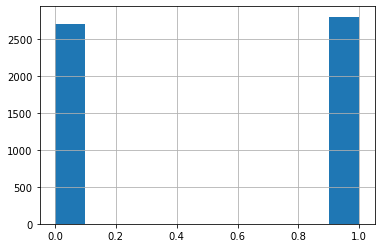

In [6]:
# distribution of outcome variable
train['Choice'].hist()

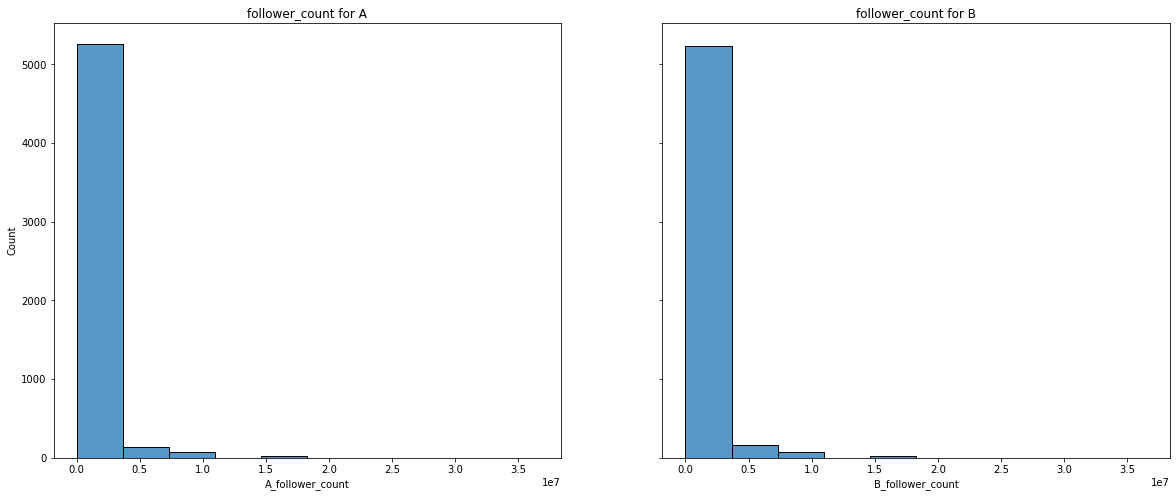

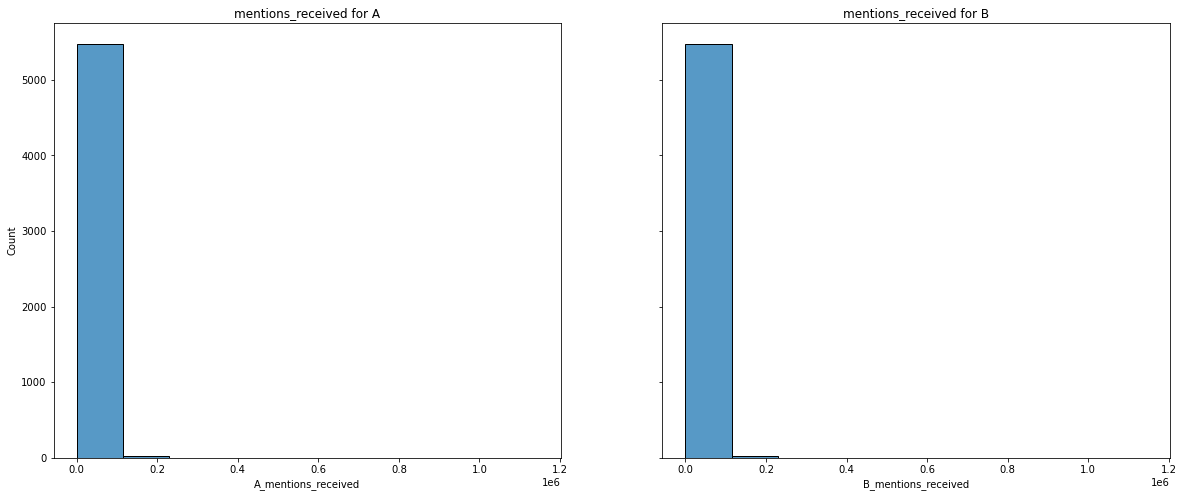

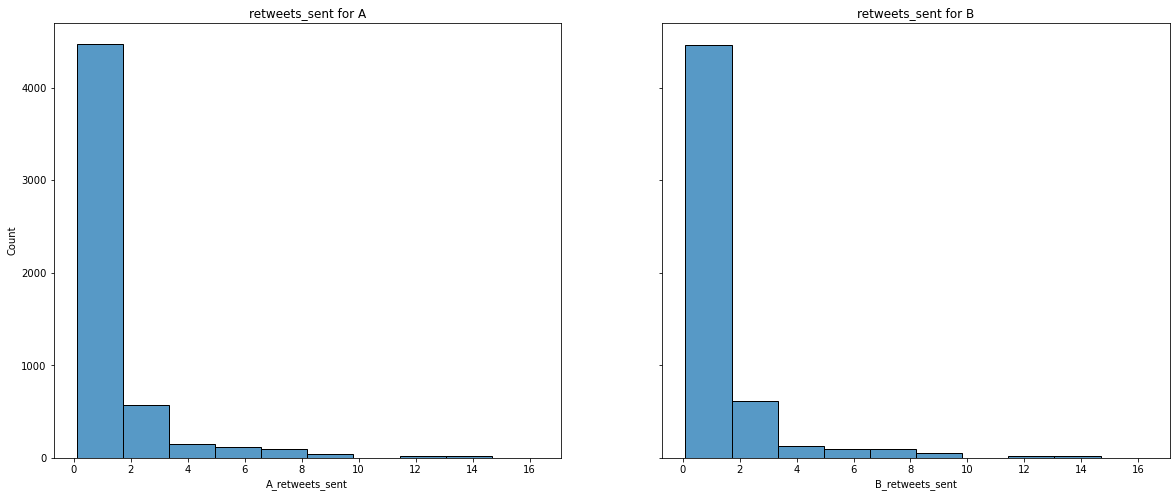

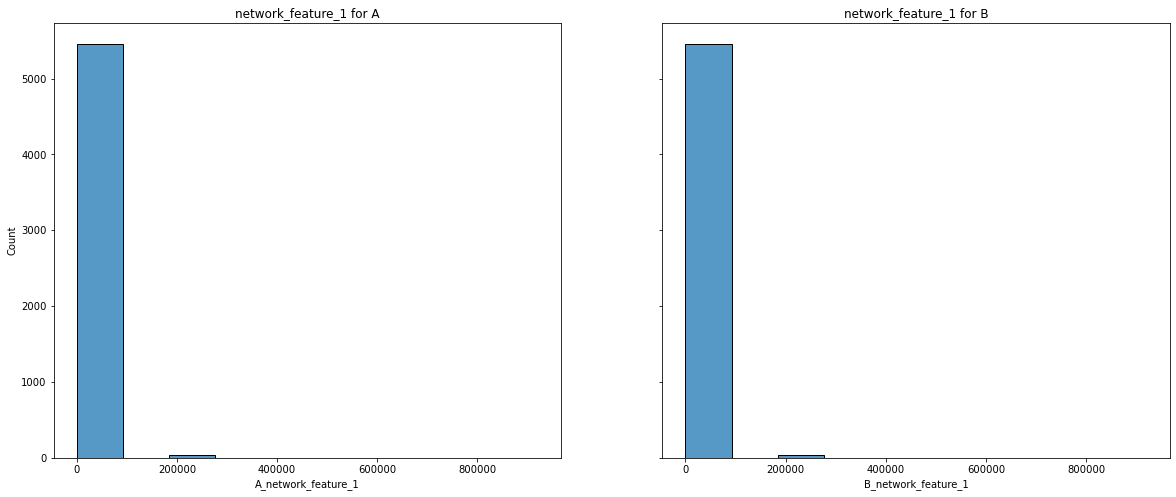

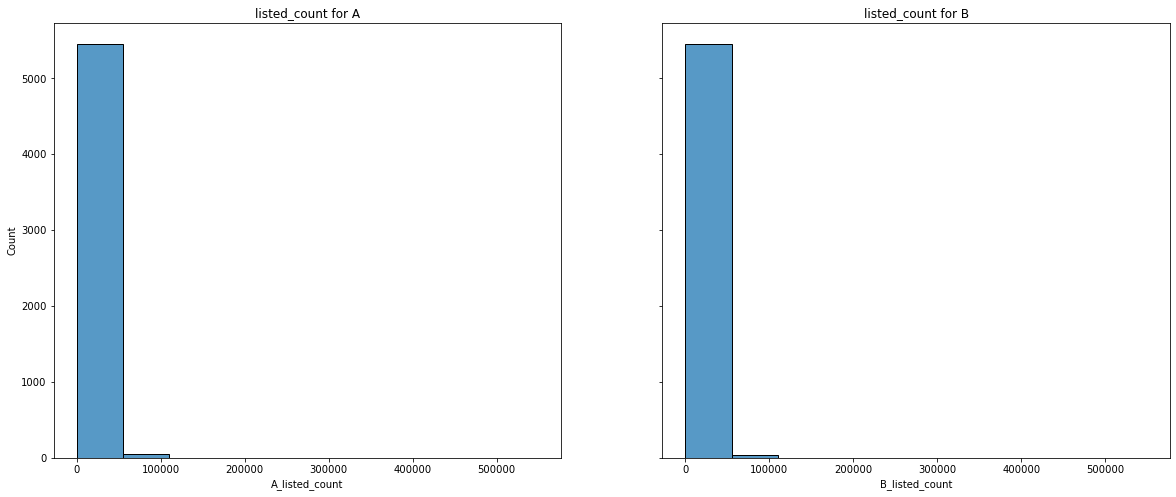

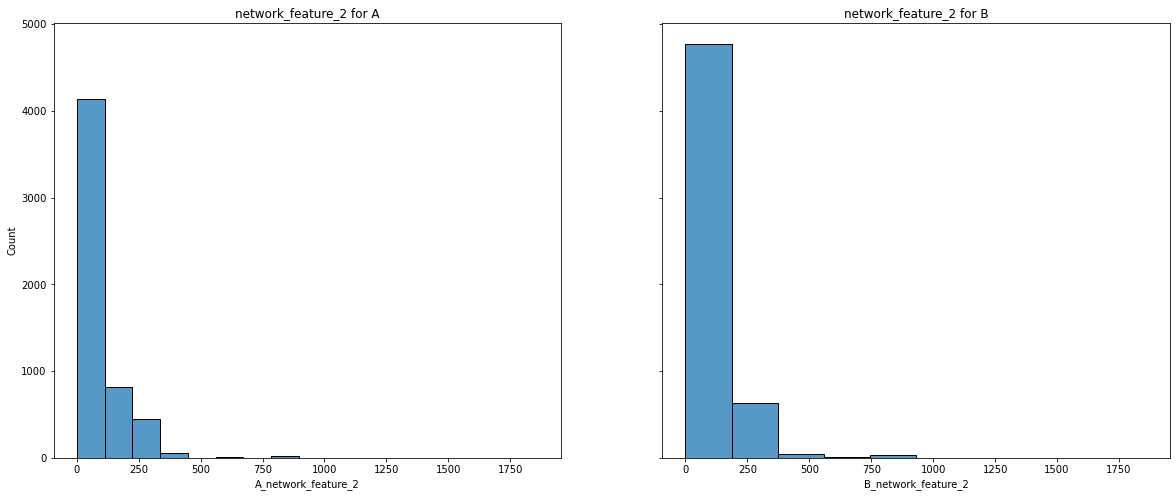

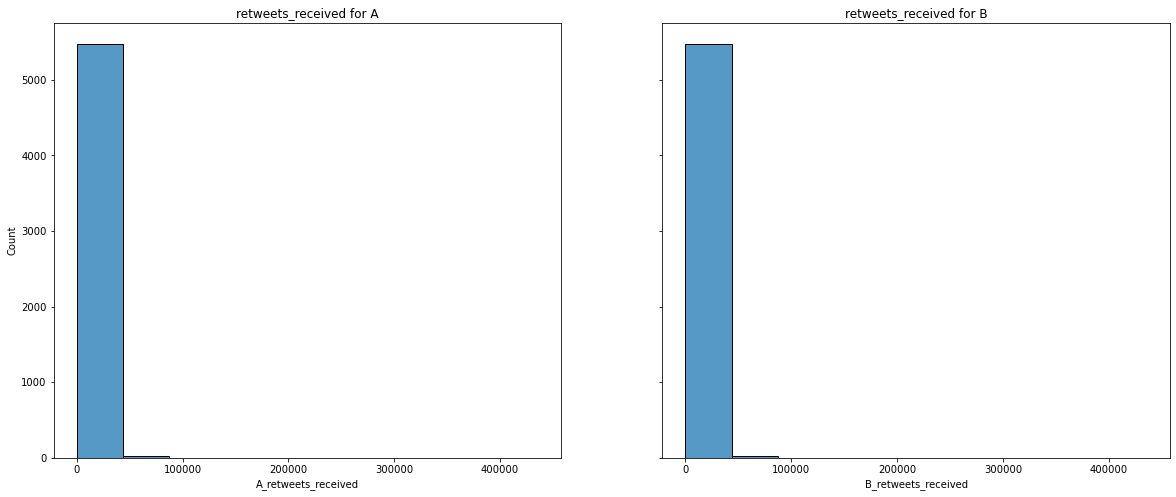

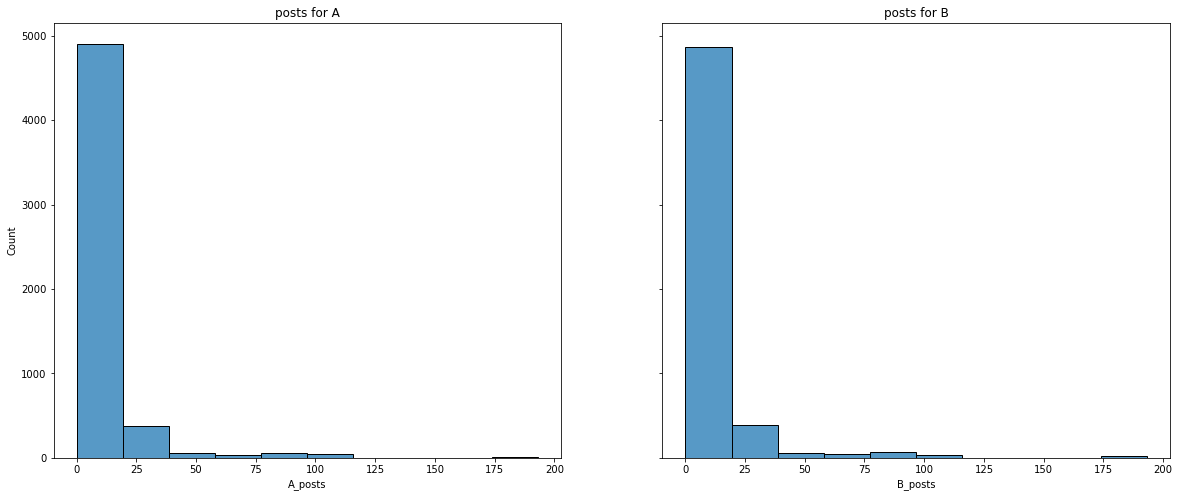

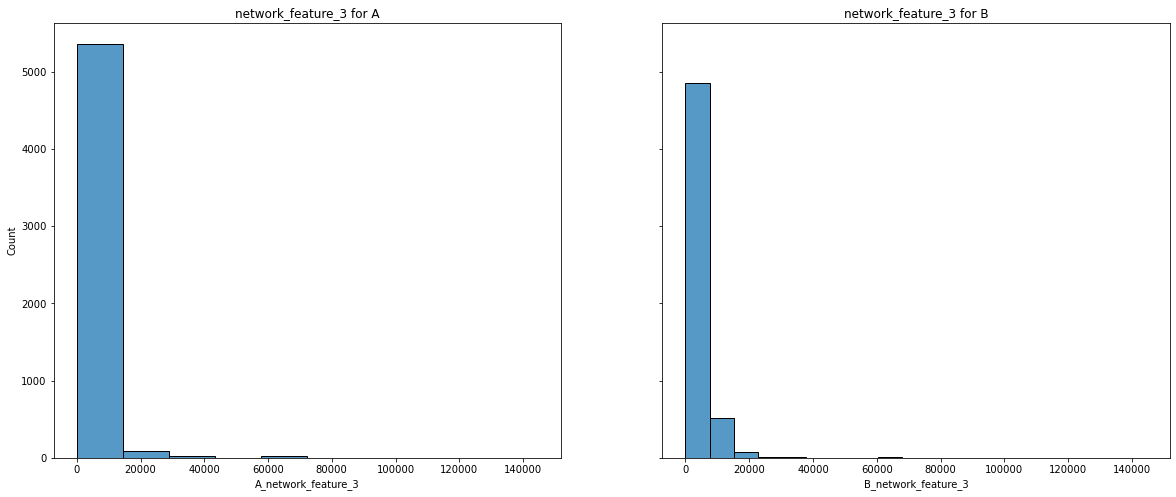

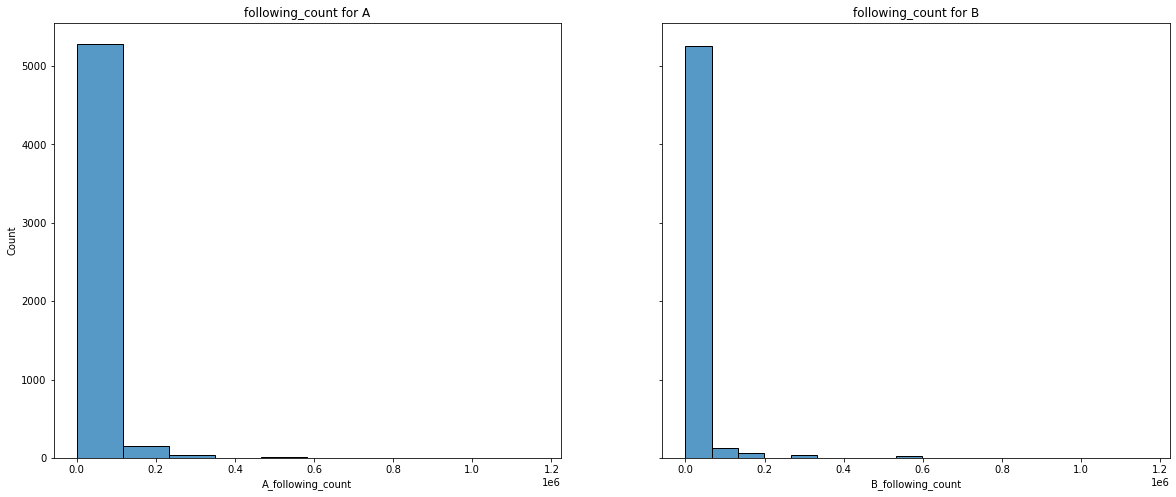

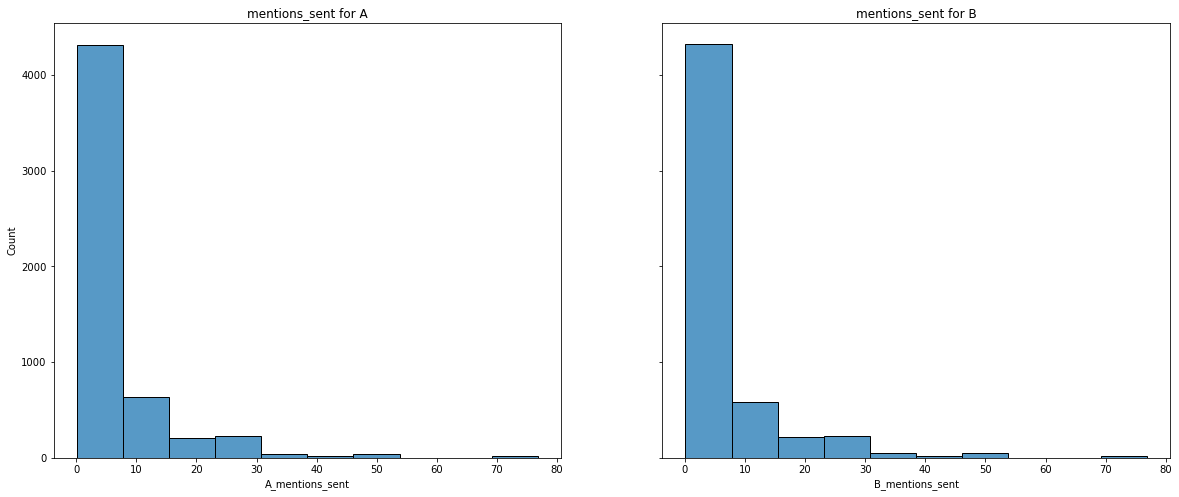

In [7]:
# distribution of each variable
for att in attributes:
    dat_a = train['A_' + att]
    dat_b = train['B_' + att]
    
    f, (ax_a, ax_b) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(20, 8))

    # assigning a graph to each ax
    sns.histplot(dat_a, ax=ax_a, bins=10)
    ax_a.set_title(att + ' for A')
    
    sns.histplot(dat_b, ax=ax_b, bins=10)
    ax_b.set_title(att + ' for B')

**Observations** - 
1. Distributions for each attributes are very similar hence it makes more sense to take a ratio of A/B as features as it will amplify the relative difference between the two choices. Also adjustments need to be made for the features which can have possible zero value 

2. Also the distribution are mostly skewed hence a box cox transformation to get normal distribution can probably provide a better accuracy post taking ratio

3. Outcome variable, *Choice* is evenly distributed hence there is no need to handle imbalance

## Feature engineering

In [8]:
# getting the list of variable with zero minimum
desc_stat = train.describe().T[1:]
zero_min_cols = list(desc_stat[desc_stat['min'] <= 0].index)
zero_min_cols

['A_following_count',
 'A_listed_count',
 'A_network_feature_1',
 'A_network_feature_2',
 'A_network_feature_3',
 'B_following_count',
 'B_listed_count',
 'B_network_feature_1',
 'B_network_feature_2',
 'B_network_feature_3']

### Ratio of A/B

In [9]:
# creating new train dataframe with transformed variables
new_train = pd.DataFrame()
new_train['choice'] = train['Choice']

# iterating over each attribute to take a ratio
for att in attributes:
    att_a = 'A_' + att
    att_b = 'B_' + att
    
    dat_a = train[att_a]
    dat_b = train[att_b]
    
    if att_a in zero_min_cols:
        dat_a += 1
    
    if att_b in zero_min_cols:
        dat_b += 1
    
    new_train['A/B_' + att] = dat_a/dat_b

In [10]:
print(new_train.shape)
new_train.head()

(5500, 12)


,choice,A/B_follower_count,A/B_mentions_received,A/B_retweets_sent,A/B_network_feature_1,A/B_listed_count,A/B_network_feature_2,A/B_retweets_received,A/B_posts,A/B_network_feature_3,A/B_following_count,A/B_mentions_sent
0,0,0.006616,0.037846,0.302336,0.044776,0.002367,2.188676,0.025227,0.051819,5.921078,0.010165,0.012250
1,0,0.549921,2.233769,1.968943,2.256098,0.142148,0.146154,2.884551,4.836513,0.454001,1.389870,1.768866
2,0,2.018222,34.713213,5.882446,24.000000,0.492754,6.170103,26.966469,5.951102,21.560109,2.517598,8.888426
3,0,0.001022,0.013425,0.014022,0.003971,0.010753,0.122603,0.000711,0.088176,0.069561,0.000454,0.048327
4,1,6.035081,6.890807,2.977058,6.418605,14.516484,2.594026,10.330091,5.229015,1.421241,0.504089,4.121682


In [11]:
# sorting columns for ease
cols = sorted(new_train.columns)
new_train = new_train[cols]

# checking the descriptive stats of the data
new_train.describe().T

,count,mean,std,min,25%,50%,75%,max
A/B_follower_count,5500.0,609.063937,9180.138456,0.000004,0.062139,1.014562,17.551299,4.771410e+05
A/B_following_count,5500.0,178.406229,4050.360615,0.000003,0.179344,1.039417,5.910295,2.753725e+05
A/B_listed_count,5500.0,150.331877,1147.396530,0.000026,0.086704,1.075518,12.756741,4.520300e+04
A/B_mentions_received,5500.0,1406.198292,26896.696784,0.000002,0.054930,0.987268,19.754961,1.727666e+06
A/B_mentions_sent,5500.0,14.685839,45.076328,0.001308,0.162619,1.000000,6.254171,7.642482e+02
A/B_network_feature_1,5500.0,468.133834,5068.510080,0.000005,0.065650,1.000000,16.917187,2.137190e+05
A/B_network_feature_2,5500.0,9.686371,38.800237,0.002456,0.255487,1.000000,3.733242,8.370000e+02
A/B_network_feature_3,5500.0,176.286457,1276.470256,0.000031,0.341131,0.951415,2.845916,4.456714e+04
A/B_posts,5500.0,14.195777,63.460866,0.000521,0.170097,1.000000,5.583226,1.921054e+03
A/B_retweets_received,5500.0,1223.315069,12865.123172,0.000003,0.052735,1.000000,21.228532,5.208749e+05


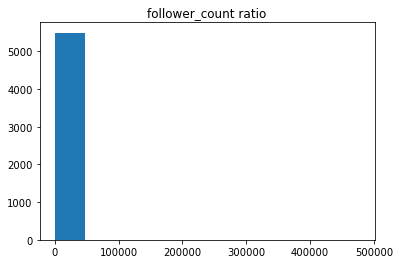

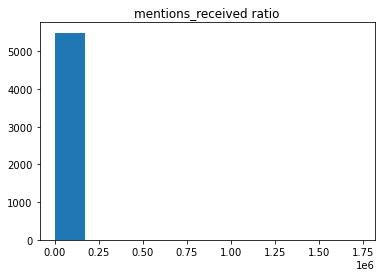

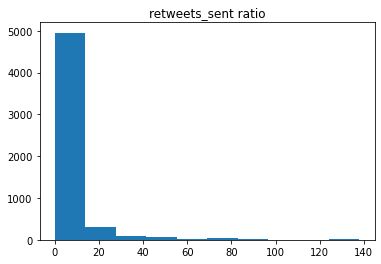

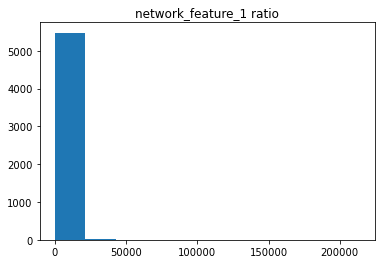

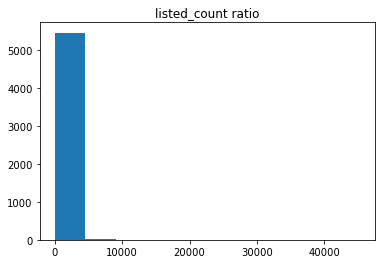

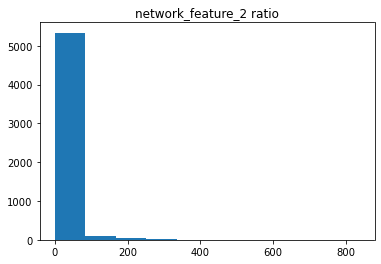

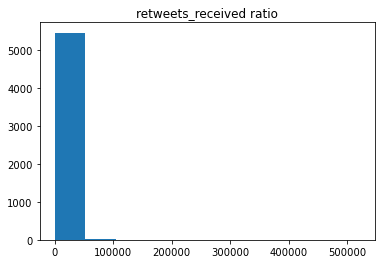

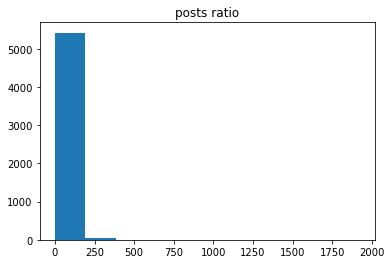

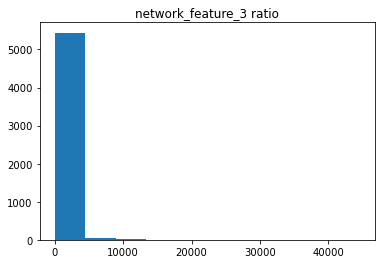

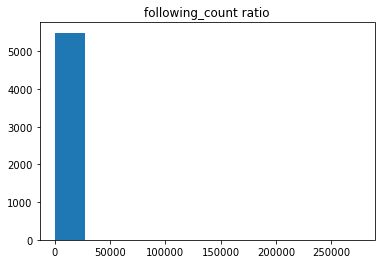

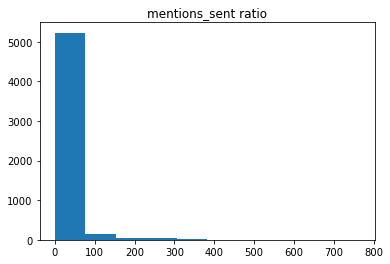

In [12]:
# visualizing the ratio variables created
for att in attributes:
    col = 'A/B_' + att
    dat_ab = new_train[col]
    
    # assigning a graph to each ax
    plt.hist(dat_ab, bins=10)
    plt.title(att + ' ratio')
    
    plt.show()

**Note** -
1. All the attributes doesn't resemble normal like distributions
2. All the attributes have non-zero minimum but are very close to 0

Based on the distribution Box cox transformation needs to be done. Post the transformation, *MinMaxScaling* might be required

### Box Cox transformation

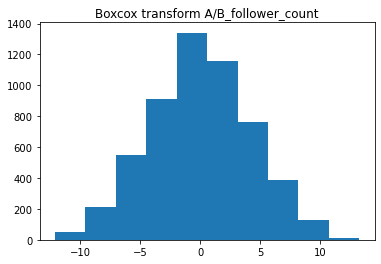

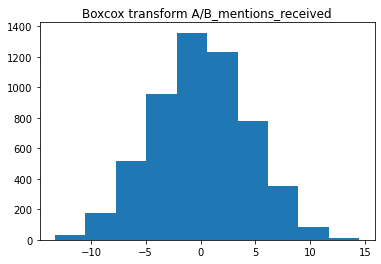

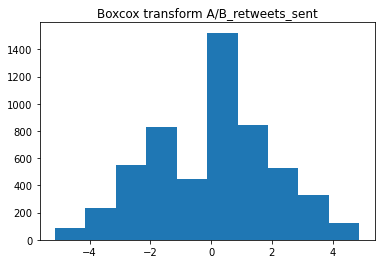

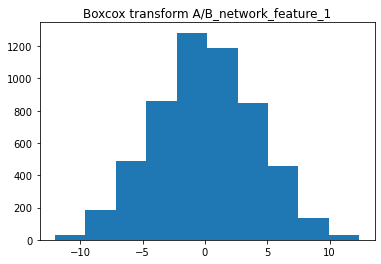

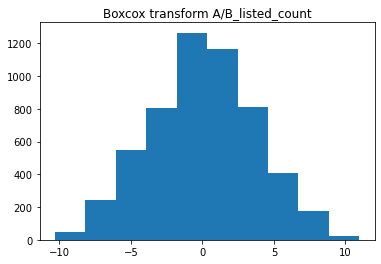

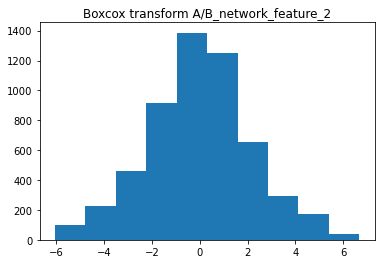

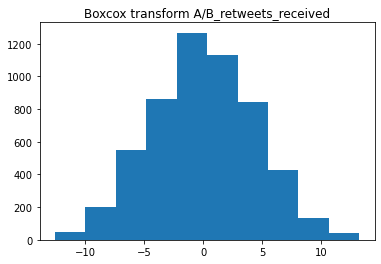

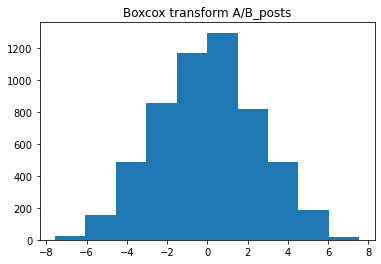

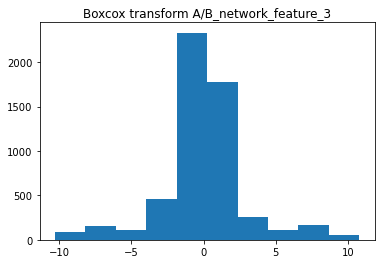

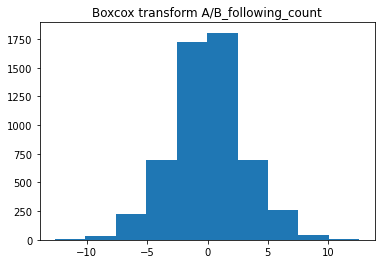

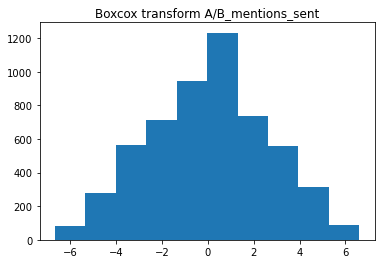

In [13]:
lambda_dict = {}

for att in attributes:
    col = 'A/B_' + att
    dat_ab = new_train[col]

    # box cox transfomation
    dat_upd, l = boxcox(dat_ab)
    
    # histogram of transformed data
    plt.title('Boxcox transform ' + col)
    plt.hist(dat_upd)
    plt.show()

    # updating the column
    new_train[col + '_bc'] = dat_upd
    
    # storing the lambda values
    lambda_dict[col] = l

In [14]:
# descriptive stats of data post boxcox
new_train.iloc[:, -11:].describe().T

,count,mean,std,min,25%,50%,75%,max
A/B_follower_count_bc,5500.0,0.038921,4.187246,-12.128910,-2.768494,0.014455,2.875701,13.297719
A/B_mentions_received_bc,5500.0,0.023540,4.321747,-13.288536,-2.896852,-0.012813,2.988538,14.481763
A/B_retweets_sent_bc,5500.0,0.001479,1.967453,-5.142216,-1.277992,0.000000,1.285699,4.877085
A/B_network_feature_1_bc,5500.0,0.028616,4.033498,-12.038152,-2.718154,0.000000,2.834029,12.380218
A/B_listed_count_bc,5500.0,0.039810,3.662209,-10.316576,-2.432231,0.072813,2.560284,10.974063
A/B_network_feature_2_bc,5500.0,-0.009197,2.159072,-6.057224,-1.367053,0.000000,1.314980,6.670165
A/B_retweets_received_bc,5500.0,0.031337,4.400936,-12.592422,-2.938134,0.000000,3.060040,13.250677
A/B_posts_bc,5500.0,-0.012587,2.492225,-7.570493,-1.771927,0.000000,1.719256,7.550783
A/B_network_feature_3_bc,5500.0,-0.016720,2.874036,-10.301404,-1.074703,-0.049803,1.046628,10.782976
A/B_following_count_bc,5500.0,0.033638,3.024690,-12.652326,-1.717331,0.038660,1.777892,12.585525


In [15]:
# lambda values post transformation
lambda_dict

{'A/B_follower_count': 0.0025696945679236564,
 'A/B_mentions_received': 0.0011520824914060031,
 'A/B_retweets_sent': -0.004147508718332155,
 'A/B_network_feature_1': 0.001423180094186756,
 'A/B_listed_count': 0.004372225426375166,
 'A/B_network_feature_2': -0.0026502048037810072,
 'A/B_retweets_received': 0.0010045179434671851,
 'A/B_posts': -0.0003447867301909838,
 'A/B_network_feature_3': 0.001358644220695189,
 'A/B_following_count': 0.0007578992356926833,
 'A/B_mentions_sent': -0.0016207708784317825}

1. The lambda values for each attributes, which are very close to 0, indicates that a log transformation would have been sufficient to get normal-like distribution.
2. Based on descriptive statistics, all attributes have zero mean, but standard deviation is not hence scaling is required 
3. Since the distribution of each attribute is very clean, *StandardScaler* will be used

### Scaling

In [16]:
bc_ratio_attributes = ['A/B_' + att + '_bc' for att in attributes]

# creating scaler to fit and transform
scaler = StandardScaler()
scaler.fit(new_train[bc_ratio_attributes])

new_train_scaled = pd.DataFrame(
    scaler.transform(new_train[bc_ratio_attributes]), 
    columns=bc_ratio_attributes)
new_train_scaled['choice'] = new_train['choice']

In [17]:
new_train_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
A/B_follower_count_bc,5500.0,-5.611673e-18,1.000091,-2.906191,-0.670529,-0.005844,0.677543,3.166760
A/B_mentions_received_bc,5500.0,2.708944e-17,1.000091,-3.080534,-0.675805,-0.008413,0.686127,3.345762
A/B_retweets_sent_bc,5500.0,-1.092535e-16,1.000091,-2.614631,-0.650377,-0.000752,0.652792,2.478357
A/B_network_feature_1_bc,5500.0,-1.005256e-17,1.000091,-2.991910,-0.681051,-0.007095,0.695592,3.062534
A/B_listed_count_bc,5500.0,-1.873249e-17,1.000091,-2.828164,-0.675075,0.009013,0.688301,2.985970
A/B_network_feature_2_bc,5500.0,1.293914e-17,1.000091,-2.801471,-0.628965,0.004260,0.613364,3.093908
A/B_retweets_received_bc,5500.0,1.622944e-17,1.000091,-2.868687,-0.674798,-0.007121,0.688258,3.004029
A/B_posts_bc,5500.0,-4.799191e-18,1.000091,-3.032869,-0.705996,0.005051,0.694962,3.035063
A/B_network_feature_3_bc,5500.0,1.148576e-17,1.000091,-3.578806,-0.368151,-0.011512,0.370018,3.758017
A/B_following_count_bc,5500.0,-5.642961e-17,1.000091,-4.194518,-0.578945,0.001661,0.576725,4.150187


## Modeling

### Baseline
Baseline will be setup based on the raw dataset that is available without any transformations and hyperparameter tuning

Logistic regression will be the choice of model as stated in the assignment description. Goal is to get the maximum accuracy with Logistic regresion model class.

In [18]:
# auc score calculation for kaggle comparision
def auc_roc(y_train, y_pred):
    fpr, tpr, thresholds = roc_curve(y_train, y_pred, pos_label=1)
    plt.plot(fpr, tpr)
    print('Threshold', thresholds)
    auc_score = auc(fpr,tpr)
    return auc_score

In [19]:
def output_report(y_train, y_pred):
    print('Accuracy is ', round(100*accuracy_score(y_train, y_pred),2 ), '%')
    cm = confusion_matrix(y_train, y_pred)
    print('Confusion Matrix')
    cm = np.round(100*cm/len(y_train), 2)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot()
    plt.show()
    print(classification_report(y_train, y_pred))

In [20]:
# creating lr instance
baseline_lr = LogisticRegression(solver='liblinear')

# creating train set X & y
X_train_blr = train.iloc[:, 1:]
y_train = train['Choice']

baseline_lr.fit(X_train_blr, y_train)
y_blr = baseline_lr.predict(X_train_blr)

Accuracy is  74.38 %
Confusion Matrix


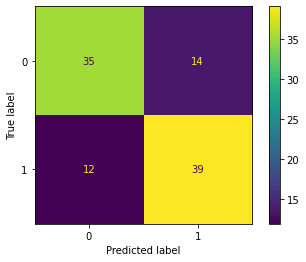

              precision    recall  f1-score   support

           0       0.75      0.72      0.73      2698
           1       0.74      0.77      0.75      2802

    accuracy                           0.74      5500
   macro avg       0.74      0.74      0.74      5500
weighted avg       0.74      0.74      0.74      5500



In [21]:
output_report(y_train, y_blr)

### Modeling on transformed data: Box-Cox + Ratio

In [22]:
# creating lr instance
transformed_lr = LogisticRegression(solver='liblinear')

# creating train set X & y
X_train = new_train[bc_ratio_attributes]

transformed_lr.fit(X_train, y_train)
y_trans_blr = transformed_lr.predict(X_train)

Accuracy is  76.93 %
Confusion Matrix


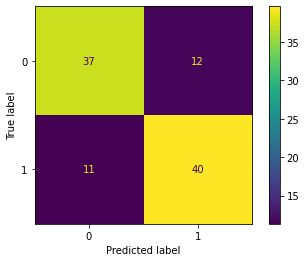

              precision    recall  f1-score   support

           0       0.77      0.76      0.76      2698
           1       0.77      0.78      0.77      2802

    accuracy                           0.77      5500
   macro avg       0.77      0.77      0.77      5500
weighted avg       0.77      0.77      0.77      5500



In [23]:
output_report(y_train, y_trans_blr)

### Modeling on transformed data: Box-Cox + Ratio + Scaling

In [24]:
# creating lr instance
transformed_lr2 = LogisticRegression(solver='liblinear')

# creating train set X & y
X_train = new_train_scaled[bc_ratio_attributes]

transformed_lr2.fit(X_train, y_train)
y_trans_blr = transformed_lr2.predict(X_train)

Accuracy is  76.98 %
Confusion Matrix


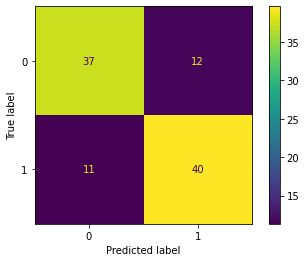

              precision    recall  f1-score   support

           0       0.77      0.76      0.76      2698
           1       0.77      0.78      0.77      2802

    accuracy                           0.77      5500
   macro avg       0.77      0.77      0.77      5500
weighted avg       0.77      0.77      0.77      5500



In [25]:
output_report(y_train, y_trans_blr)

### Hyper parameter tuning 
Parameters to choose - 
1. L1/L2/ElasticNet
2. C
3. L1 ratio

In [26]:
lr = LogisticRegression(solver='saga')

# creating train set X & y
X_train = new_train_scaled[bc_ratio_attributes]

# creating grid for parameter search
parameters = {'penalty':('l1', 'l2', 'elasticnet', 'none'), 
              'C':[10**x for x in range(-5, 5)],
              'l1_ratio': [x/10 for x in range(11)]
             }

# creating grid seach cv model
tuning_lr = GridSearchCV(lr, parameters, cv=5, n_jobs=-1, scoring='accuracy')
tuning_lr.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(solver='saga'), n_jobs=-1,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                               1000, 10000],
                         'l1_ratio': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,
                                      0.8, 0.9, 1.0],
                         'penalty': ('l1', 'l2', 'elasticnet', 'none')},
             scoring='accuracy')

In [27]:
cv_results = pd.DataFrame(tuning_lr.cv_results_)
cv_results.sort_values('rank_test_score', inplace=True)

# top 10 parameter sets
cv_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_l1_ratio,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
214,0.030247,0.003054,0.002503,0.000604,0.1,0.9,elasticnet,"{'C': 0.1, 'l1_ratio': 0.9, 'penalty': 'elasti...",0.774545,0.757273,0.781818,0.771818,0.763636,0.769818,0.008555,1
170,0.036383,0.004169,0.002668,0.000677,0.01,0.9,elasticnet,"{'C': 0.01, 'l1_ratio': 0.9, 'penalty': 'elast...",0.775455,0.753636,0.775455,0.770000,0.772727,0.769455,0.008164,2
180,0.036567,0.011367,0.003207,0.001020,0.1,0.1,l1,"{'C': 0.1, 'l1_ratio': 0.1, 'penalty': 'l1'}",0.774545,0.757273,0.780909,0.770909,0.763636,0.769455,0.008264,3
176,0.033929,0.002086,0.002022,0.000305,0.1,0.0,l1,"{'C': 0.1, 'l1_ratio': 0.0, 'penalty': 'l1'}",0.774545,0.757273,0.780909,0.770909,0.763636,0.769455,0.008264,3
184,0.030296,0.002648,0.002113,0.000223,0.1,0.2,l1,"{'C': 0.1, 'l1_ratio': 0.2, 'penalty': 'l1'}",0.774545,0.757273,0.780909,0.770909,0.763636,0.769455,0.008264,3
188,0.031095,0.003251,0.002113,0.000569,0.1,0.3,l1,"{'C': 0.1, 'l1_ratio': 0.3, 'penalty': 'l1'}",0.774545,0.757273,0.780909,0.770909,0.763636,0.769455,0.008264,3
192,0.030935,0.002715,0.002208,0.000516,0.1,0.4,l1,"{'C': 0.1, 'l1_ratio': 0.4, 'penalty': 'l1'}",0.774545,0.757273,0.780909,0.770909,0.763636,0.769455,0.008264,3
196,0.033368,0.006492,0.002665,0.000373,0.1,0.5,l1,"{'C': 0.1, 'l1_ratio': 0.5, 'penalty': 'l1'}",0.774545,0.757273,0.780909,0.770909,0.763636,0.769455,0.008264,3
200,0.030541,0.002625,0.002645,0.000376,0.1,0.6,l1,"{'C': 0.1, 'l1_ratio': 0.6, 'penalty': 'l1'}",0.774545,0.757273,0.780909,0.770909,0.763636,0.769455,0.008264,3
204,0.029491,0.002759,0.002576,0.000672,0.1,0.7,l1,"{'C': 0.1, 'l1_ratio': 0.7, 'penalty': 'l1'}",0.774545,0.757273,0.780909,0.770909,0.763636,0.769455,0.008264,3


In [28]:
# best set of estimators
print('Best parameters from Grid Search with ', tuning_lr.best_params_)

Best parameters from Grid Search with  {'C': 0.1, 'l1_ratio': 0.9, 'penalty': 'elasticnet'}


In [29]:
# fitting the best parameters set
best_lr = tuning_lr.best_estimator_
best_lr.fit(X_train, y_train)
y_pred_best = best_lr.predict(X_train)

Accuracy is  77.13 %
Confusion Matrix


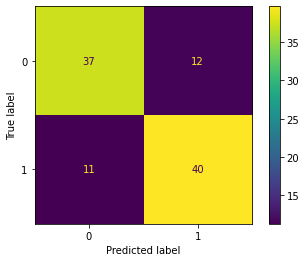

              precision    recall  f1-score   support

           0       0.77      0.76      0.77      2698
           1       0.77      0.78      0.78      2802

    accuracy                           0.77      5500
   macro avg       0.77      0.77      0.77      5500
weighted avg       0.77      0.77      0.77      5500



In [30]:
output_report(y_train, y_pred_best)

Threshold [2 1 0]


0.7711427662862861

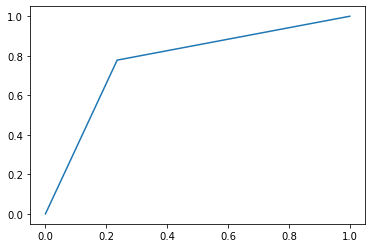

In [31]:
auc_roc(y_train, y_pred_best)

In [42]:
train['Choice_pred'] = y_pred_best

### Variable importance

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

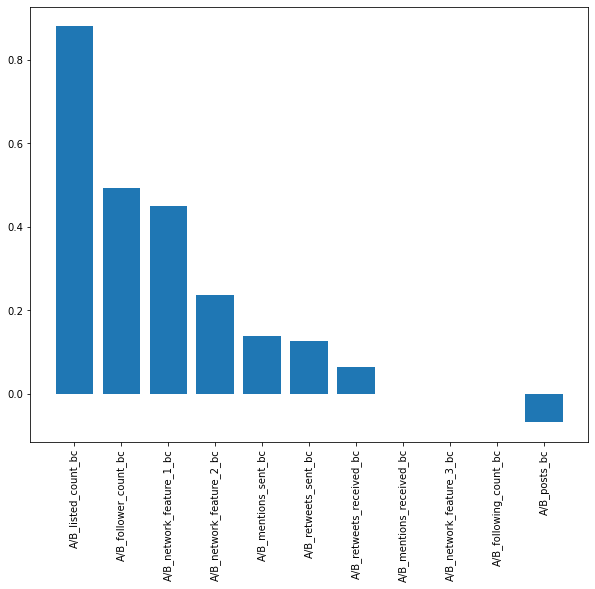

In [54]:
# get coefficient values
coef = pd.DataFrame({'features': X_train.columns, 'coef_value': best_lr.coef_[0]})
coef.sort_values('coef_value', ascending=False, inplace=True)

# plotting importance
plt.figure(figsize=(10, 8))
plt.bar(coef.features, coef.coef_value)
plt.xticks(rotation=90)

1. Listed count is the most important feature followed by follower counts
2. Network feature 1 & 2 are also among the important features, but coef. of feature 3 is zero (due to regularization)
3. Number of post have a negative impact on the influencer, which indicates that follower prefer less number of high quality tweets rather than someone who tweets a lot regularly

## Test data predictions

In [33]:
test

,A_follower_count,A_following_count,A_listed_count,A_mentions_received,A_retweets_received,A_mentions_sent,A_retweets_sent,A_posts,A_network_feature_1,A_network_feature_2,A_network_feature_3,B_follower_count,B_following_count,B_listed_count,B_mentions_received,B_retweets_received,B_mentions_sent,B_retweets_sent,B_posts,B_network_feature_1,B_network_feature_2,B_network_feature_3
0,614689,400,5729,199.618296,67.812469,9.366192,0.359534,4.094488,669,39.193741,2565.612519,1404323,563,20057,967.720642,579.431128,4.473798,0.805680,6.241806,4027,57.643839,3201.293706
1,739581,10723,1279,102.026750,96.771319,1.537322,1.054358,3.467754,432,11.191686,966.193995,756715,12949,1311,38.260522,10.697567,12.845793,1.584284,12.106662,144,209.717241,21496.565517
2,3638,3341,85,2.793577,1.402703,2.594089,0.598150,3.802143,11,9.416667,489.083333,488750,320,3673,1207.190077,599.721600,0.842022,0.593199,7.044735,3918,7.859818,637.983300
3,613,1259,31,1.326041,0.356943,6.249678,2.323064,7.488116,4,5.000000,275.000000,13456,3599,1072,10.300222,3.828561,1.624092,0.100503,1.614287,43,113.840909,2537.772727
4,1352348,331,15647,19129.848662,14552.733991,2.065418,0.580955,16.281502,52580,3.092448,597.563636,1481379,147521,15043,9902.070379,5012.055876,10.438460,0.100503,193.072418,28564,10.964144,1035.955493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5947,614689,400,5729,199.618296,67.812469,9.366192,0.359534,4.094488,669,39.193741,2565.612519,3302480,550744,20006,936.636126,206.101772,41.317189,0.595962,42.813704,3691,69.150872,3456.096107
5948,3764,703,222,5.270621,1.601159,2.338333,0.100503,1.596539,18,139.444444,4573.888889,28613,3557,9,0.751434,0.295998,0.100503,0.100503,0.100503,3,2.666667,218.333333
5949,1611042,936,10346,388.093282,65.719046,2.086961,0.349327,1.096322,1637,35.500603,3538.089264,871652,140,13838,133.213345,56.027747,2.622550,1.121160,2.622550,562,135.158451,5187.500000
5950,631958,674,7522,614.968745,329.330091,4.052279,1.340566,12.305035,2536,35.838659,2231.568979,580544,2799,7371,296.978205,135.831429,15.033026,4.807180,8.262063,1201,87.183775,3547.782285


In [34]:
# taking ratios
for att in attributes:
    att_a = 'A_' + att
    att_b = 'B_' + att
    
    dat_a = test[att_a]
    dat_b = test[att_b]
    
    if att_a in zero_min_cols:
        dat_a += 1
    
    if att_b in zero_min_cols:
        dat_b += 1
    
    test['A/B_' + att] = dat_a/dat_b
    

# box cox transformation
for att in attributes:
    col = 'A/B_' + att
    dat_ab = test[col]

    # box cox transfomation
    dat_upd = boxcox(dat_ab, lmbda=lambda_dict[col])

    # updating the column
    test[col + '_bc'] = dat_upd
    
# scaling
test_scaled = pd.DataFrame(
    scaler.transform(test[bc_ratio_attributes]), 
    columns=bc_ratio_attributes)

In [35]:
# creating submission file
test_sub = pd.DataFrame(best_lr.predict_proba(test_scaled)[:, 1])
test_sub.reset_index(inplace=True)
test_sub.columns = ['Id', 'Choice']
test_sub['Id'] += 1

test_sub.to_csv('submission1.csv', index=False)

## Financial Lift

Financial list is defined at the increase in profit for the seller if one of the influencer is paid money for two tweets rather than equally paying both the influencers.

**Baseline profit**

Profit expectations when both influencer A and B are paid $5 for one tweet.

**Analytical model profit**

Profit expecation when only one of the influencer is being paid $10 for two tweets based on model prediction.

**Perfect Analytical model profit**

Profit expecation when only one of the influencer is being paid $10 for two tweets based on ideal model that gives 100% accuracy.

In [36]:
# probability for buying a product when one tweet or two tweets
prob_one_tweet = 0.01/100
prob_two_tweet = 0.015/100
margin = 10

### Baseline profit

In [37]:
# based on the actual influence getting the number of people that could have bought the product
train['follower_bought_baseline'] = np.where(
    train['Choice'] == 0, 
    train['B_follower_count'], 
    train['A_follower_count'])
units_baseline = round((train['follower_bought_baseline']*prob_one_tweet).sum())
profit_baseline = units_baseline*margin
spend_baseline = len(train) * 5 * 2

print('Total units sold ', units_baseline, 'Total profit sold ', profit_baseline, 'Total spend', spend_baseline)

Total units sold  537657 Total profit sold  5376570 Total spend 55000


### Analytical model profit

In [38]:
# people who can probably buy the product will be depended on whether prediction is correct or not 
train['correct_influencer'] = np.where(
    train['Choice'] == train['Choice_pred'],
    1, 0
)

train['follower_bought_analytical'] = np.select(
    [(train['correct_influencer'] == 1) & (train['Choice'] == 0), 
     (train['correct_influencer'] == 1) & (train['Choice'] == 1)], 
    [train['B_follower_count'], 
     train['A_follower_count']],
    default=0)
units_analytical = round((train['follower_bought_analytical']*prob_two_tweet).sum())
profit_analytical = units_analytical*margin
spend_analytical = len(train) * 10 

print('Total units sold ', units_analytical, 'Total profit sold ', profit_analytical, 'Print total spend', spend_analytical)

Total units sold  747263 Total profit sold  7472630 Print total spend 55000


### Perfect model profit

In [39]:
# perfect 
units_perfect = round((train['follower_bought_baseline']*prob_two_tweet).sum())
profit_perfect = units_perfect*margin
spend_perfect = len(train) * 10

print('Total units sold ', units_perfect, 'Total profit sold ', profit_perfect, 'Total spend', spend_perfect)

Total units sold  806485 Total profit sold  8064850 Total spend 55000


In [40]:
print('Financial lift with current model ', profit_analytical - profit_baseline)
print('Financial lift with perfect model ', profit_perfect - profit_baseline)

Financial lift with current model  2096060
Financial lift with perfect model  2688280
